In [1]:
import pandas as pd
import joblib

clf = joblib.load("rf_area_classifier_full.pkl")

new_data = pd.read_csv("../2_Feature_Extraction/extract_features/tracking_features.csv")  
X_new = new_data.drop(columns=["tracking_id"])

new_data["predicted_label"] = clf.predict(X_new)
new_data.to_csv("new_tracking_predictions.csv", index=False)



<Axes: title={'center': 'Predicted Label Distribution'}, xlabel='predicted_label'>

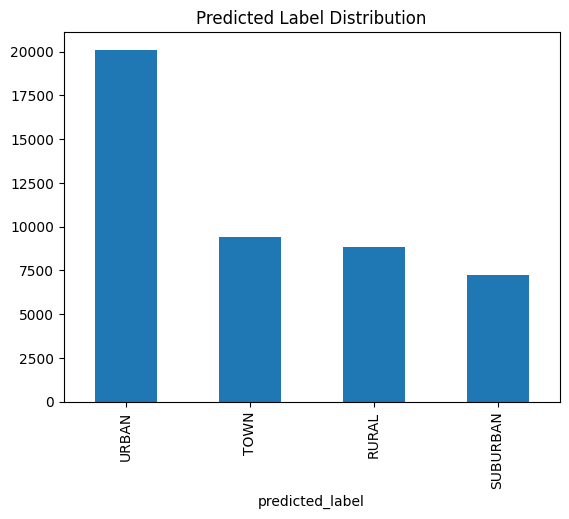

In [2]:
new_data["predicted_label"].value_counts().plot(kind="bar", title="Predicted Label Distribution")


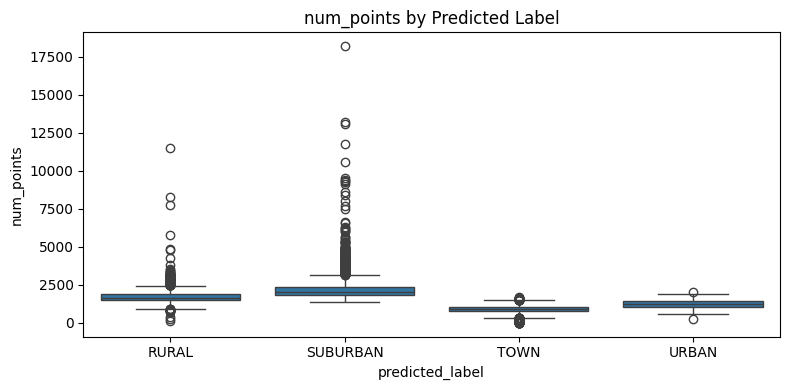

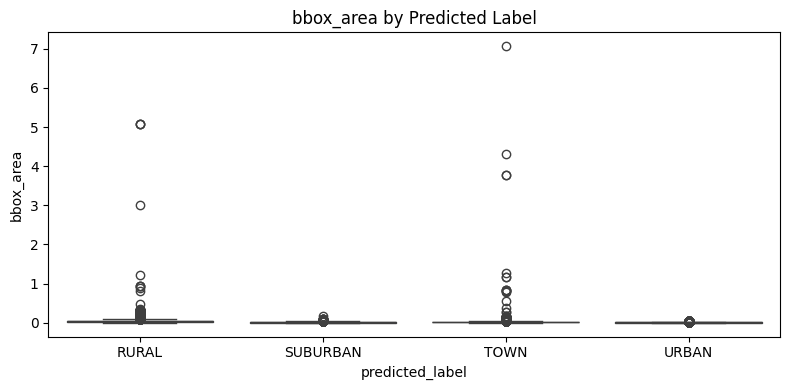

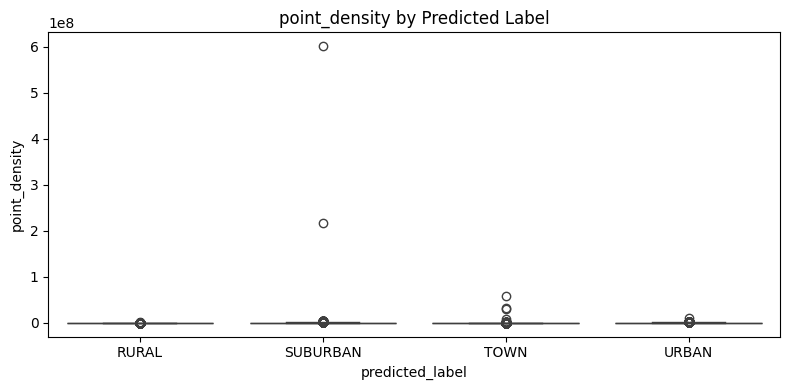

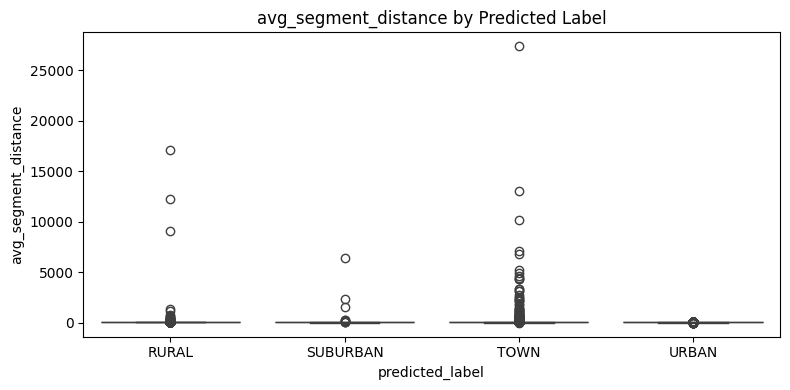

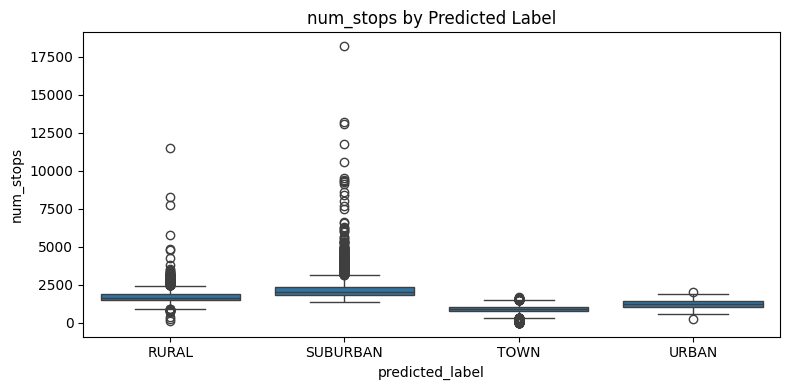

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

features_to_plot = ["num_points", "bbox_area", "point_density", "avg_segment_distance", "num_stops"]

for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=new_data, x="predicted_label", y=feature)
    plt.title(f"{feature} by Predicted Label")
    plt.tight_layout()
    plt.show()


In [4]:
df = pd.read_csv("new_tracking_predictions.csv")

for label in df["predicted_label"].unique():
    print(f"\n=== {label} ===")
    display(df[df["predicted_label"] == label].sample(3, random_state=42))



=== RURAL ===


tracking_id  num_points  bbox_area  point_density  \
40888        88588        1302   0.024282   53617.009271   
12714        28179        1239   0.033651   36817.951103   
15757        33975        1480   0.021388   69196.056238   

       avg_segment_distance  num_stops      duration      length  \
40888            117.261494       1302  323490000000  153.322379   
12714             92.984952       1239  287960000000  115.667778   
15757             76.189316       1480  340760000000  114.090101   

      predicted_label  
40888           RURAL  
12714           RURAL  
15757           RURAL


=== SUBURBAN ===


tracking_id  num_points  bbox_area  point_density  \
6983         17060        2850   0.038796   7.345911e+04   
43854        97152        1786   0.005282   3.380936e+05   
36869        79503        1888   0.001303   1.448313e+06   

       avg_segment_distance  num_stops      duration      length  \
6983              48.919131       2850  333320000000  140.301040   
43854             49.417833       1786  327760000000   95.564976   
36869             34.894096       1888  355190000000   69.968459   

      predicted_label  
6983         SUBURBAN  
43854        SUBURBAN  
36869        SUBURBAN


=== TOWN ===


tracking_id  num_points  bbox_area  point_density  \
21005        44590         737   0.010362   71118.538367   
22865        47502         970   0.011969   81036.851983   
23152        48015         854   0.010958   77924.364846   

       avg_segment_distance  num_stops      duration     length  \
21005             70.555387        737  235950000000  52.926435   
22865             84.525386        970  297800000000  83.109029   
23152             88.178684        854  304060000000  75.993996   

      predicted_label  
21005            TOWN  
22865            TOWN  
23152            TOWN


=== URBAN ===


tracking_id  num_points  bbox_area  point_density  \
26976        57249        1279   0.001286  993913.640448   
10943        25407        1463   0.008363  174921.860300   
15083        32536        1619   0.003985  406144.075389   

       avg_segment_distance  num_stops      duration      length  \
26976             38.646268       1279  290160000000   51.527798   
10943             77.764859       1463  338830000000  114.269085   
15083             47.579450       1619  349380000000   78.901676   

      predicted_label  
26976           URBAN  
10943           URBAN  
15083           URBAN

/tmp/ipykernel_18097/1753934054.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=2, random_state=42))["tracking_id"]


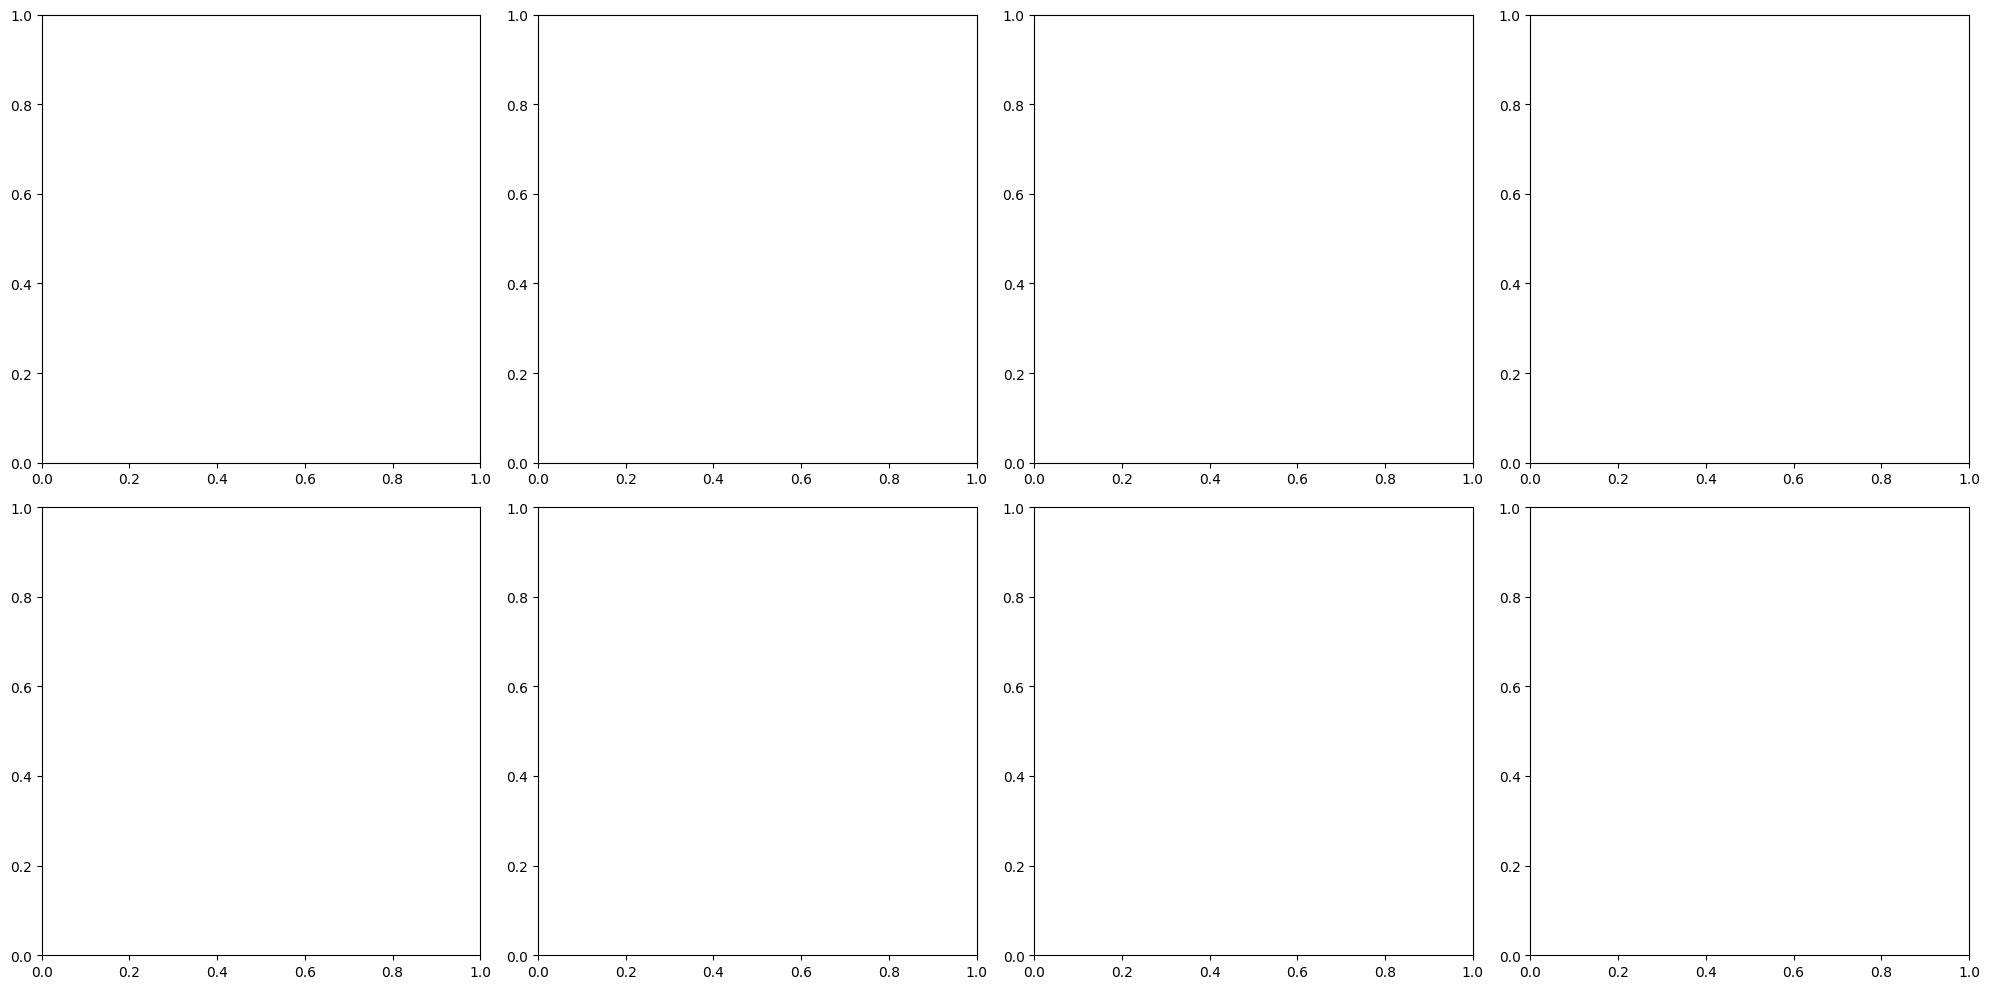

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import LineString

predicted_df = pd.read_csv("new_tracking_predictions.csv")
waypoints_df = pd.read_parquet("../2_Feature_Extraction/data/filtered_waypoints.parquet")

sampled_ids = (
    predicted_df.groupby("predicted_label")
    .apply(lambda x: x.sample(n=2, random_state=42))["tracking_id"]
    .explode()
    .tolist()
)

sampled_routes = waypoints_df[waypoints_df["id_tracking"].isin(sampled_ids)]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

color_map = {
    "RURAL": "red",
    "SUBURBAN": "orange",
    "TOWN": "blue",
    "URBAN": "green"
}

for i, tracking_id in enumerate(sampled_ids):
    ax = axes[i]
    route = sampled_routes[sampled_routes["id_tracking"] == tracking_id].sort_values("sequence")
    coords = list(zip(route["longitude"], route["latitude"]))
    label = predicted_df[predicted_df["tracking_id"] == tracking_id]["predicted_label"].values[0]

    if len(coords) < 2:
        continue

    line = LineString(coords)
    gdf = gpd.GeoDataFrame(index=[0], geometry=[line], crs="EPSG:4326").to_crs(epsg=3857)

    gdf.plot(ax=ax, color=color_map.get(label, "gray"), linewidth=2)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    ax.set_title(f"{label} - ID {tracking_id}", fontsize=9)
    ax.set_axis_off()

for j in range(len(sampled_ids), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
# plt.savefig("Figures/predicted_tracking_routes_mapgrid.png", dpi=300)
plt.show()


/tmp/ipykernel_18097/2194588078.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=trackings_per_group, random_state=42))["tracking_id"]


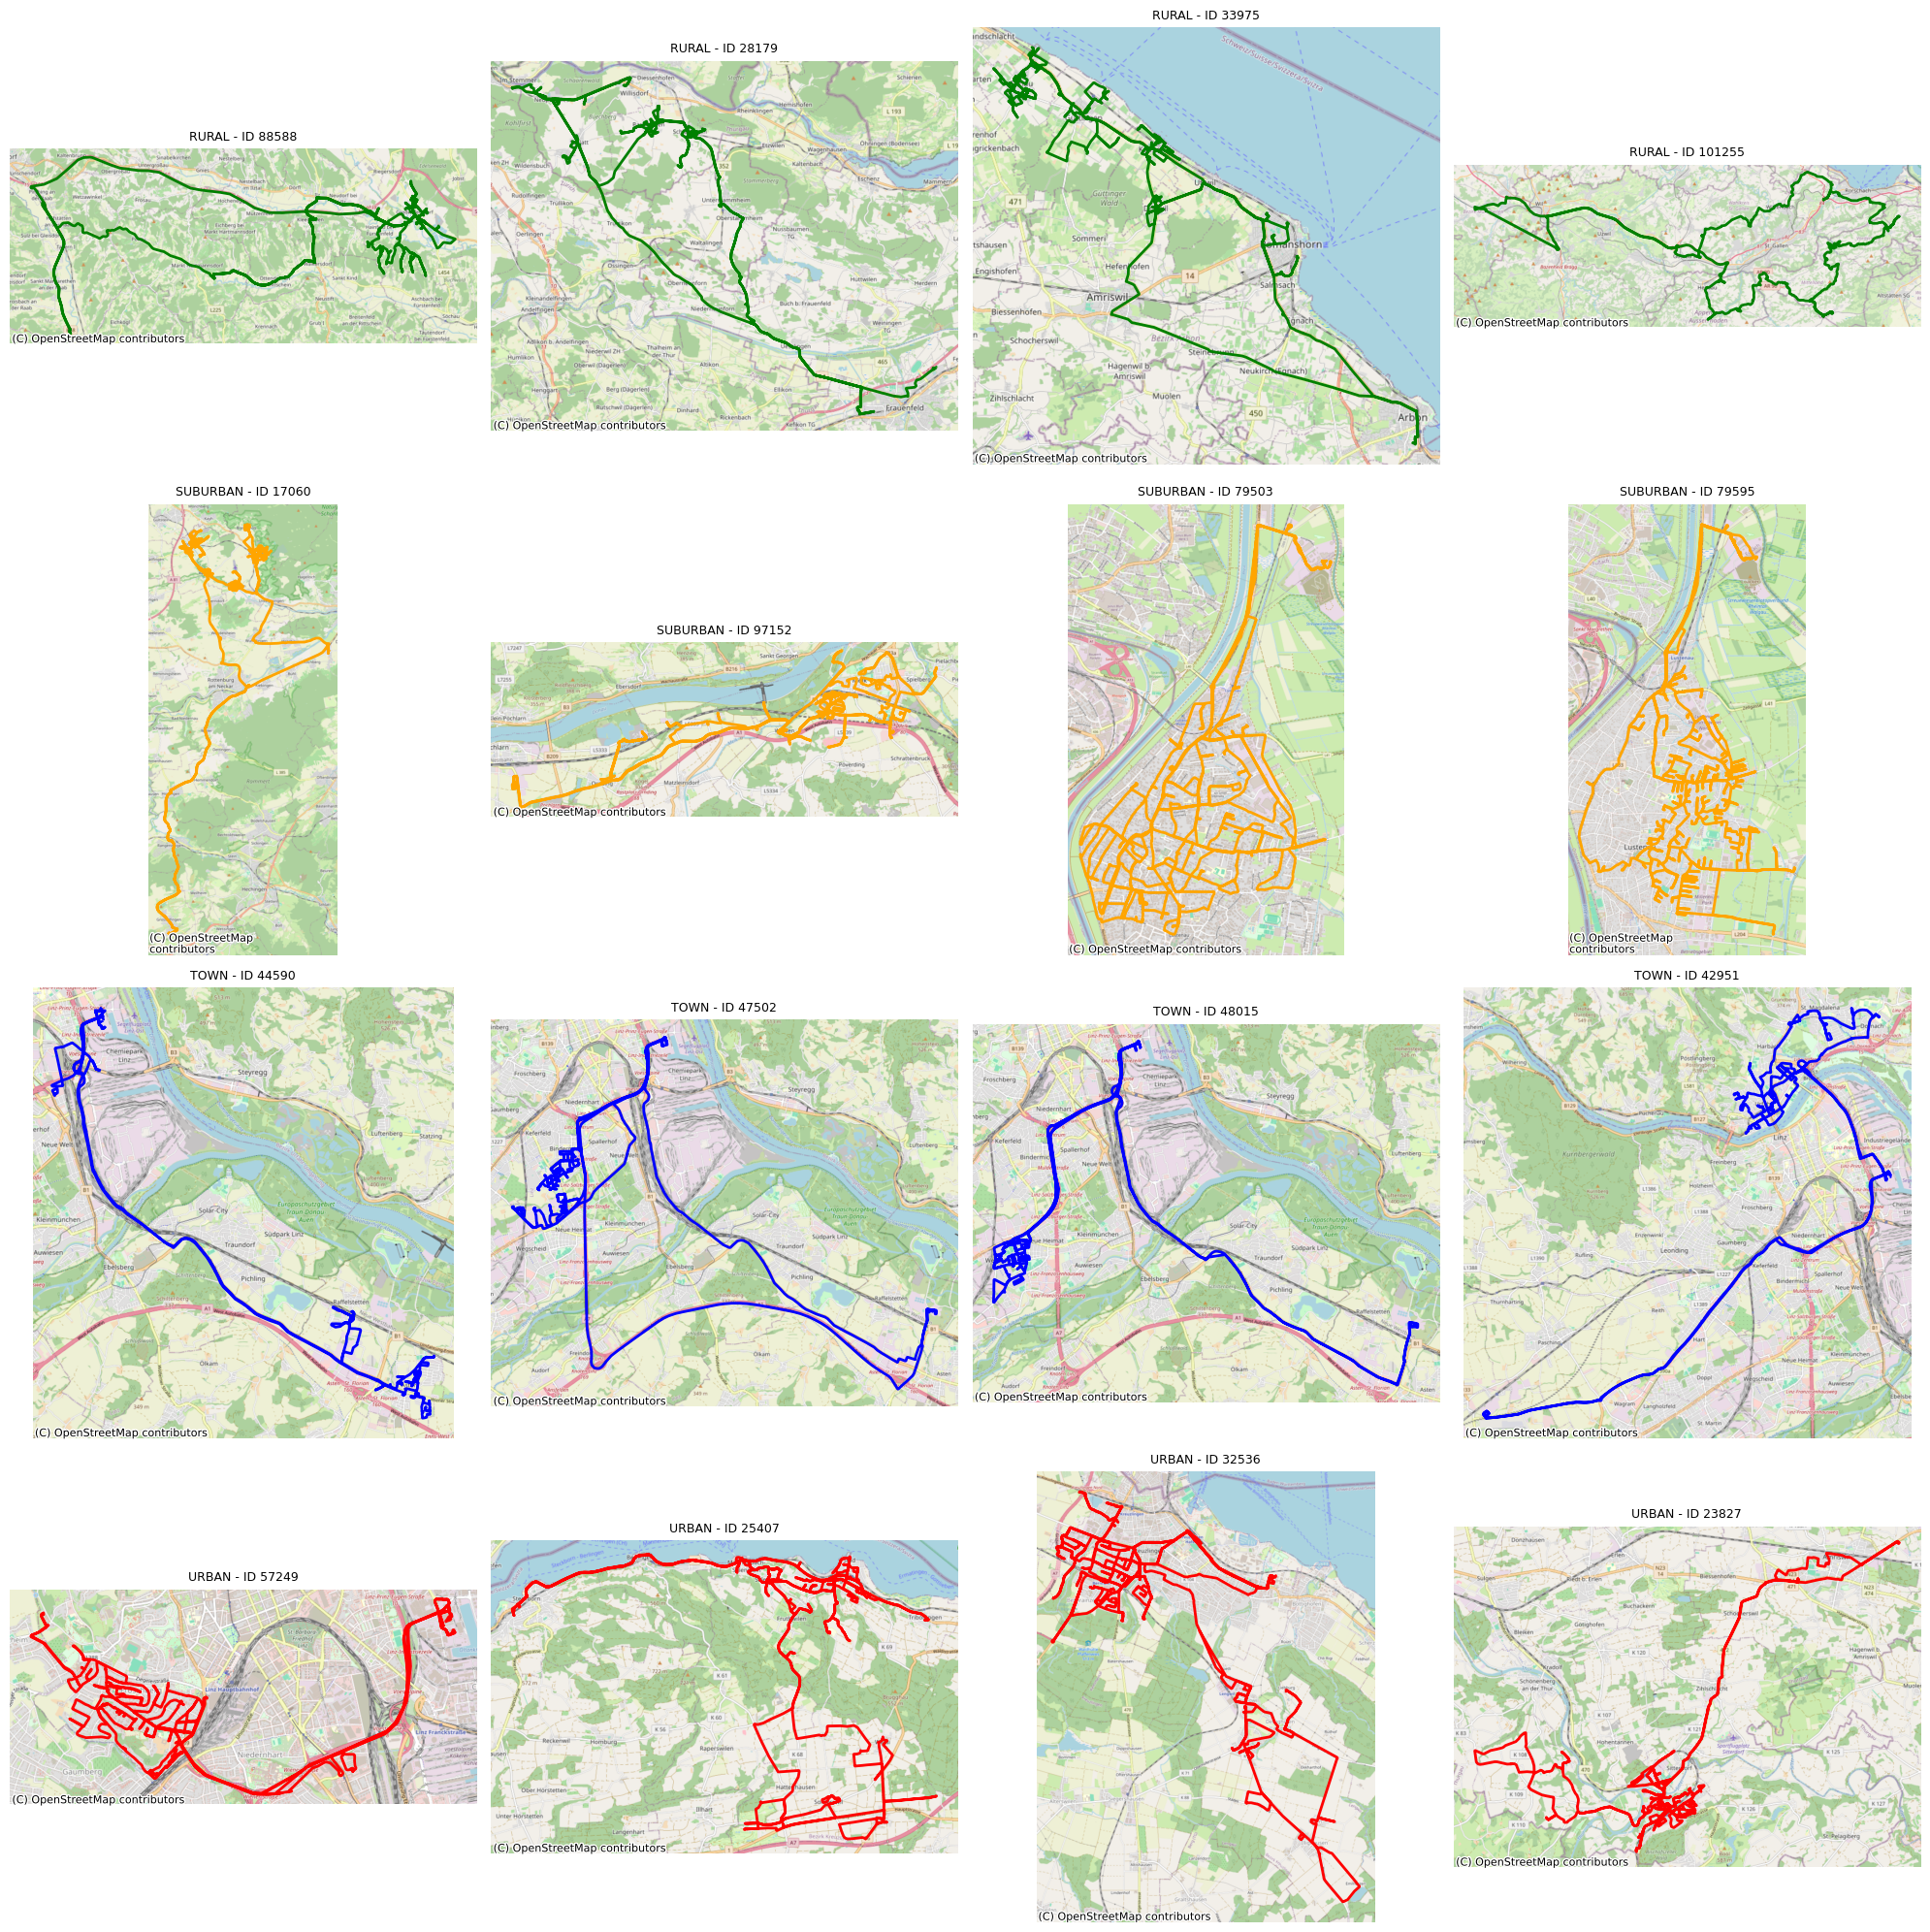

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import LineString
import pyarrow.parquet as pq

# Load predictions (small file)
predicted_df = pd.read_csv("new_tracking_predictions.csv")

trackings_per_group = 4

# Sample 2 IDs per predicted label
sampled_ids = (
    predicted_df.groupby("predicted_label")
    .apply(lambda x: x.sample(n=trackings_per_group, random_state=42))["tracking_id"]
    .explode()
    .tolist()
)

# Efficiently load only the required trackings from large Parquet file
table = pq.read_table(
    "../Data_Preperation/filtered_data_full_1.parquet",
    filters=[("id_tracking", "in", sampled_ids)]
)
sampled_routes = table.to_pandas()

# Plotting
fig, axes = plt.subplots(trackings_per_group, 4, figsize=(20, 20))
axes = axes.flatten()

color_map = {
    "RURAL": "green",
    "SUBURBAN": "orange",
    "TOWN": "blue",
    "URBAN": "red"
}

for i, tracking_id in enumerate(sampled_ids):
    ax = axes[i]
    route = sampled_routes[sampled_routes["id_tracking"] == tracking_id].sort_values("sequence")
    coords = list(zip(route["longitude"], route["latitude"]))
    label = predicted_df[predicted_df["tracking_id"] == tracking_id]["predicted_label"].values[0]

    if len(coords) < 2:
        continue

    line = LineString(coords)
    gdf = gpd.GeoDataFrame(index=[0], geometry=[line], crs="EPSG:4326").to_crs(epsg=3857)

    gdf.plot(ax=ax, color=color_map.get(label, "gray"), linewidth=2)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    ax.set_title(f"{label} - ID {tracking_id}", fontsize=9)
    ax.set_axis_off()

# Hide any unused subplots
for j in range(len(sampled_ids), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

